# Simple decision rules give high accuracy for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [50]:
from datetime import datetime
from functools import reduce
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import pandas as pd
import pyreadr
import random
from scipy.io import arff
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn import tree, ensemble
from sklearn.tree import export_text
from sklearn.metrics import f1_score, recall_score, precision_score
import time
import xml.etree.ElementTree as ET

In [6]:
PROJ_PATH = "/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection"

def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"Starting {func.__name__} at {start_time}")
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Finished {func.__name__} at {end_time}. Execution time: {end_time - start_time} s")
        return result
    return wrapper

def extract_users(data_path):
    """
    Load json file with user dictionaries and return.
    """
    with open(data_path) as f:
        d = json.load(f)
        profs = [ent['user'] for ent in d]
    return profs


def preprocess(X, drop_cols, one_hot_cols):
    """
    Drop columns listed by drop_cols, turn one_hot_cols into 
    one-hot variables since decision trees must be fitted on numerical data.
    """
    X.drop(columns=drop_cols, inplace=True)
    one_hot = pd.get_dummies(X, columns=one_hot_cols, drop_first=True)
    return one_hot


def preprocess_users(profs, labels_path):
    """
    Preprocessing user dictionaries.
    - Convert created_at to datetime
    - Read in labels
    - Run preprocess
    - Return dataframe, one_hot dataframe and labels
    """
    df = pd.DataFrame(profs).set_index("id")
    df["created_at"] = df["created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp())
    labels = pd.read_csv(labels_path, sep="\t", header=None, names=["id", "label_str"], index_col="id")
    labels.loc[labels['label_str']=="human", 'label'] = 0
    labels.loc[labels['label_str']=="bot", 'label'] = 1
    df, labels = df.align(labels, join="inner", axis=0)
    df.reset_index(inplace=True)
    labels = labels['label']
    one_hot = preprocess(df, COLUMNS_TO_DROP + ['profile_banner_url', 'entities', 'id_str', 'following', 'follow_request_sent', 'notifications', 'translator_type'], DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'is_translation_enabled', 'has_extended_profile'])
    return df, one_hot, labels


def fit(X, y, method=None, depth=3):
    """
    Fit a decision tree (or method, if provided) using features X, labels y and maximum depth equal to depth. 
    """
    if method is None:
        # Use decision tree
        clf = tree.DecisionTreeClassifier(max_depth=depth)
    else:
        clf = method
    clf = clf.fit(X, y)
    return clf
 

def score(clf, X, y, method=None, silent=False):
    """
    Score trained model, and print out results if not silent.
    """
    if method is None and not silent:
        r = export_text(clf, feature_names=list(X.columns), show_weights=True)
        print(r)
    accuracy = clf.score(X, y)
    preds = clf.predict(X)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    if (not silent):
        print(f"Accuracy:", accuracy)
        print(f"Precision", precision)
        print(f"Recall:", recall)
        print(f"F1:", f1)
    return accuracy, precision, recall, f1


def fit_and_score(X, y, method=None, depth=3, silent=False):
    """ 
    Fit model, print out the ascii tree and scores and return the model/scores.
    """
    clf = fit(X, y, method, depth)
    accuracy, precision, recall, f1 = score(clf, X, y, method, silent)
    return clf, accuracy, precision, recall, f1

@timeit
def kfold_cv(X, y, method=None, depth=3, k=5):
    """
    Run fit_and_score k times and compute test score statistics.
    """
    inds = random.sample(range(len(X)), len(X))
    scores = []
    for i in range(k):
        print(f"Fold {i} in progress")
        # Train test split
        fold_size = (len(X) // k)+1
        train_X = pd.concat([X.iloc[:i*fold_size], X.iloc[(i+1)*fold_size:]])
        test_X = X.iloc[i*fold_size:(i+1)*fold_size]
        train_y = [label for j,label in enumerate(y) if ((j < i*fold_size) or (j >= (i+1)*fold_size))]
        test_y = [label for j,label in enumerate(y) if ((j >= i*fold_size) and (j < (i+1)*fold_size))]
        # Fit
        clf = fit(train_X, train_y, depth=depth)
        scr = score(clf, test_X, test_y, method, True)
        scores.append(scr)
    avg_scores = [sum([row[i] for row in scores])/k for i in range(4)]
    return avg_scores
    
@timeit
def train_test_fit_and_score(X, y, depth=3):
    """ Train test split. """
    train, test, train_labels, test_labels = train_test_split(X, y, test_size=0.3)
    clf, *_ = fit_and_score(train, train_labels, depth=depth, silent=True)
    score(clf, test, test_labels)


def nonnumeric(df):
    """
    Print out columns that contain NA or have dtype=object.
    """
    print("Columns with NA values:", df.isnull().any()[lambda x: x])
    print("Columns with dtype=object", list(df.select_dtypes(include='object')))
    print("Columns with dtype=bool", list(df.select_dtypes(include='bool')))


@timeit
def mdi_feature_importance(clf, labels, ax):
    """
    Plot most important features.
    
    @param clf: fitted classifier
    """
    importances = clf.feature_importances_
    top10 = np.argsort(importances)[-10:] # Get top 10 most important features
    top10 = top10[::-1]
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    mdi_importances = pd.Series(importances, index=labels)
    mdi_importances[top10].plot.bar(yerr=std[top10], ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    return mdi_importances

@timeit
def permutation_feature_importance(ax, X, y, drop_cols):
    """
    Random forest feature importance on fitted model clf, features. Plot results on ax.
    Warning: computationally expensive, since refits model multiple times.
    """
    processed = preprocess(X, drop_cols, [])
    
    rf = ensemble.RandomForestClassifier(n_estimators=100)
    clf, *_ = fit_and_score(X, y, method=rf, silent=True)

    pi = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=1)
    top10 = np.argsort(pi.importances_mean)[-10:] # Get top 10 most important features
    top10 = top10[::-1]
    pi_importances = pd.Series(pi.importances_mean, index=list(X.columns))
    pi_importances[top10].plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")

def plot_metrics(one_hot, labels, soa_accuracy=None, soa_precision=None, soa_recall=None):
    """ Plot accuracy, precision and recall for different numbers of features. """
    rng = range(1,6)
    models = [fit_and_score(one_hot, labels, depth=i, silent=True) for i in rng]
    clfs, accuracies, precisions, recalls, f1s = zip(*models)
    fig, ax = plt.subplots(figsize=(7,4))
    ax.scatter(rng, accuracies, label="Accuracy")
    ax.scatter(rng, precisions, label="Precision")
    ax.scatter(rng, recalls, label="Recall")
    ax.set_title("Accuracy, precision and recall as a function of model complexity")
    ax.set_xlabel("Model complexity (tree depth)")
    ax.set_ylabel("Score")
    ax.set_ylim([0,1.05])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if soa_accuracy:
        plt.axhline(y= soa_accuracy, color='C0', linestyle='-', label="State-of-art accuracy")
    if soa_precision:
        plt.axhline(y= soa_precision, color='C1', linestyle='-', label="State-of-art precision")
    if soa_recall:
        plt.axhline(y= soa_recall, color='C2', linestyle='-', label="State-of-art recall")
    ax.legend()
    plt.tight_layout()

In [7]:
COLUMNS_TO_DROP = ['id', 
                   'name', 
                   'screen_name', 
                   'url', 
                   'profile_image_url', 
                   'profile_background_image_url_https', 
                   'description',
                   'profile_image_url_https', 
                   'profile_background_image_url', 
                   'profile_text_color', 
                   'profile_sidebar_border_color', 
                   'profile_sidebar_fill_color', 
                   'profile_background_color', 
                   'profile_link_color']
DUMMY_COLUMNS = ['lang', 
                  'time_zone', 
                  'location', 
                  'default_profile', 
                  'default_profile_image', 
                  'utc_offset',
                  'default_profile', 
                  'default_profile_image', 
                  'profile_background_tile', 
                  'utc_offset',
                  'protected', 
                  'geo_enabled',
                  'verified',
                  'profile_use_background_image']

# Network features

## "TwiBot-20: A Comprehensive Twitter Bot Detection Benchmark."

Shangbin Feng, Herun Wan, Ningnan Wang, Jundong Li, and Minnan Luo. "TwiBot-20: A Comprehensive Twitter Bot Detection Benchmark." CIKM. 2021.
https://arxiv.org/abs/2106.13088

Simple decision rule accuracy: 0.8165

State-of-art accuracy: 0.8664

In [8]:
# Load data
def load_twibot(path, drop_extra_cols=[]):
    with open(path) as f:
        twibot = json.load(f)
        twibot_labels = [int(ent['label']) for ent in twibot]
        profs = [ent['profile'] for ent in twibot]
        twibot_df = pd.DataFrame(profs)
    twibot_df["created_at"] = twibot_df["created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y ").timestamp())
    # Turn bool, string columns into ints
    for col in twibot_df:
        if (True in twibot_df):
            twibot_df[col] = twibot_df[col].astype(int)
        if (col in ['followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']):
            twibot_df[col] = twibot_df[col].astype(int)
        if (col in ['is_translation_enabled', 'has_extended_profile']):
            twibot_df[col] = twibot_df[col].astype(bool).astype(int) 
    drop_cols = COLUMNS_TO_DROP + ['profile_location', 'entities', 'id_str'] + drop_extra_cols
    twibot_one_hot = preprocess(twibot_df, drop_cols, [ent for ent in DUMMY_COLUMNS + ['is_translator', 'contributors_enabled'] if ent not in drop_cols])
    return twibot_df, twibot_one_hot, twibot_labels

twibot_df, twibot_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
twibot_validate, twibot_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")

In [14]:
# Fit and score on decision tree
print("--------Train and score on training set--------")
shared_columns = np.intersect1d(twibot_one_hot.columns, twibot_one_hot_test.columns) # Since we want to check on test set, just use common columns between train/test.
dt_clf, *_ = fit_and_score(twibot_one_hot[shared_columns], twibot_labels, depth=1)

--------Train and score on training set--------
|--- verified_True  <= 0.50
|   |--- weights: [1576.00, 4645.00] class: 1
|--- verified_True  >  0.50
|   |--- weights: [2056.00, 1.00] class: 0

Accuracy: 0.8094950471128292
Precision 0.7466645233885227
Recall: 0.9997847610848042
F1: 0.8548817520934942


In [6]:
# Score on test set for comparison to state of the art
print("--------Score on test set--------")
score(dt_clf, twibot_one_hot_test[shared_columns], twibot_labels_test)

--------Score on test set--------
|--- verified_True  <= 0.50
|   |--- weights: [1576.00, 4645.00] class: 1
|--- verified_True  >  0.50
|   |--- weights: [2056.00, 1.00] class: 0

Accuracy: 0.8165680473372781
Precision 0.7467911318553092
Recall: 1.0
F1: 0.8550434201736806


In [15]:
twibot_df, twibot_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
twibot_validate, twibot_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")
twibot_scores = []
for i in range(1, 6):
    dt_clf, *_ = fit_and_score(twibot_one_hot[shared_columns], twibot_labels, depth=i)
    scr = score(dt_clf, twibot_one_hot_test[shared_columns], twibot_labels_test, silent=True)
    twibot_scores.append(scr)

|--- verified_True  <= 0.50
|   |--- weights: [1576.00, 4645.00] class: 1
|--- verified_True  >  0.50
|   |--- weights: [2056.00, 1.00] class: 0

Accuracy: 0.8094950471128292
Precision 0.7466645233885227
Recall: 0.9997847610848042
F1: 0.8548817520934942
|--- verified_True  <= 0.50
|   |--- friends_count <= 1789.50
|   |   |--- weights: [1261.00, 3113.00] class: 1
|   |--- friends_count >  1789.50
|   |   |--- weights: [315.00, 1532.00] class: 1
|--- verified_True  >  0.50
|   |--- created_at <= 1237883904.00
|   |   |--- weights: [500.00, 1.00] class: 0
|   |--- created_at >  1237883904.00
|   |   |--- weights: [1556.00, 0.00] class: 0

Accuracy: 0.8094950471128292
Precision 0.7466645233885227
Recall: 0.9997847610848042
F1: 0.8548817520934942
|--- verified_True  <= 0.50
|   |--- friends_count <= 1789.50
|   |   |--- statuses_count <= 11.50
|   |   |   |--- weights: [198.00, 282.00] class: 1
|   |   |--- statuses_count >  11.50
|   |   |   |--- weights: [1063.00, 2831.00] class: 1
|   |

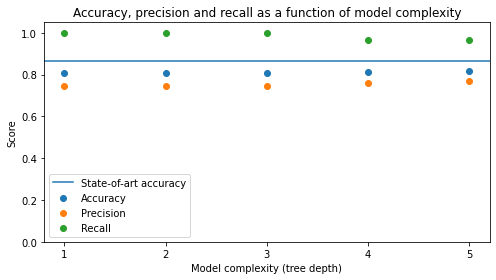

In [7]:
plot_metrics(twibot_one_hot[shared_columns], twibot_labels, soa_accuracy=0.8664)

In [8]:
# Fit and score on random forest
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf, *_ = fit_and_score(twibot_one_hot[shared_columns], twibot_labels, method=rf)

Accuracy: 1.0
Precision 1.0
Recall: 1.0
F1: 1.0


In [9]:
score(rf_clf, twibot_one_hot_test[shared_columns], twibot_labels_test, method=rf)

Accuracy: 0.8038884192730347
Precision 0.7588832487309645
Recall: 0.934375
F1: 0.8375350140056023


(0.8038884192730347, 0.7588832487309645, 0.934375, 0.8375350140056023)

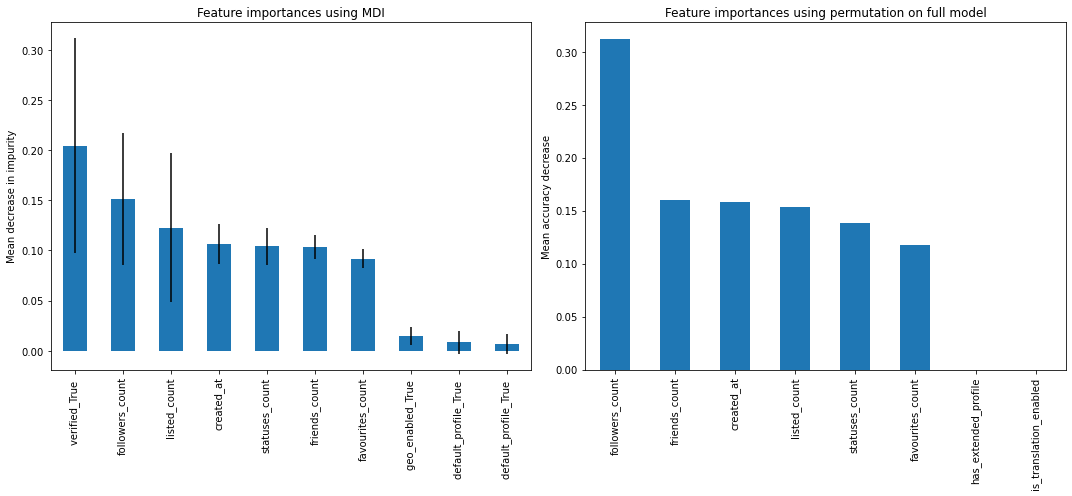

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
mdi_feature_importance(rf_clf, list(twibot_one_hot[shared_columns].columns), axes[0])
permutation_feature_importance(axes[1], twibot_df, twibot_labels, DUMMY_COLUMNS + ['is_translator', 'contributors_enabled'])
fig.tight_layout()

### Without verified

In [11]:
twibot_df, twibot_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json", ['verified'])
dt_clf, *_ = fit_and_score(twibot_one_hot, twibot_labels, depth=1)

|--- listed_count <= 225.50
|   |--- weights: [1845.00, 4265.00] class: 1
|--- listed_count >  225.50
|   |--- weights: [1787.00, 381.00] class: 0

Accuracy: 0.7310944672626238
Precision 0.6980360065466449
Recall: 0.9179939733103745
F1: 0.7930457419114912


## botometer-feedback-2019: "Arming the public with artificial intelligence to counter social bots."

Yang, Kai‐Cheng, Onur Varol, Clayton A. Davis, Emilio Ferrara, Alessandro Flammini, and Filippo Menczer. "Arming the public with artificial intelligence to counter social bots." Human Behavior and Emerging Technologies 1, no. 1 (2019): 48-61.

https://arxiv.org/pdf/1901.00912.pdf

Approx. citations: 300

Precision is `# correctly predicted bots / # predicted bots`. Recall is `# correctly predicted bots / # bots`.

Simple decision rule precision/recall: 0.86/0.68

State-of-art precision/recall: 0.84/0.7

-------------- DECISION TREE --------------
|--- friends_count <= 8.50
|   |--- favourites_count <= 70.00
|   |   |--- utc_offset_-10800.0 <= 0.50
|   |   |   |--- weights: [0.00, 23.00] class: 1.0
|   |   |--- utc_offset_-10800.0 >  0.50
|   |   |   |--- weights: [1.00, 0.00] class: 0.0
|   |--- favourites_count >  70.00
|   |   |--- listed_count <= 20.50
|   |   |   |--- weights: [0.00, 1.00] class: 1.0
|   |   |--- listed_count >  20.50
|   |   |   |--- weights: [2.00, 0.00] class: 0.0
|--- friends_count >  8.50
|   |--- friends_count <= 4219.50
|   |   |--- statuses_count <= 143.00
|   |   |   |--- weights: [47.00, 28.00] class: 0.0
|   |   |--- statuses_count >  143.00
|   |   |   |--- weights: [272.00, 32.00] class: 0.0
|   |--- friends_count >  4219.50
|   |   |--- created_at <= 1352961024.00
|   |   |   |--- weights: [36.00, 11.00] class: 0.0
|   |   |--- created_at >  1352961024.00
|   |   |   |--- weights: [22.00, 44.00] class: 1.0

Accuracy: 0.8208092485549133
Precision 0.75

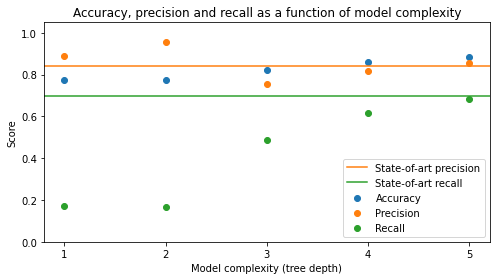

In [16]:
def analyze_bot_repo_dataset(data_path, labels_path, depth=5, soa_accuracy=None, soa_precision=None, soa_recall=None):
    profs = extract_users(data_path)
    df, one_hot, labels = preprocess_users(profs, labels_path)
    # Fit and score on decision tree
    print("-------------- DECISION TREE --------------")
    dt_clf, *_ = fit_and_score(one_hot, labels, depth=depth)
    plot_metrics(one_hot, labels, soa_accuracy=soa_accuracy, soa_precision=soa_precision, soa_recall=soa_recall)
    # Fit and score on decision tree
#     print("-------------- DECISION TREE TRAIN/TEST SPLIT --------------")
#     train_test_fit_and_score(one_hot, labels, depth=depth)
#     # Fit and score on random forest
#     print("-------------- RANDOM FOREST --------------")
#     rf = ensemble.RandomForestClassifier(n_estimators=100)
#     rf_clf, *_ = fit_and_score(one_hot, labels, method=rf)
#     fig, axes = plt.subplots(1,2, figsize=(15,7))
#     mdi_feature_importance(rf_clf, list(one_hot.columns), axes[0])
#     permutation_feature_importance(axes[1], df, labels, DUMMY_COLUMNS + ['is_translator', 'contributors_enabled'])
#     fig.tight_layout()
    return [kfold_cv(one_hot, labels, depth=i) for i in range(1,6)]

botometer_feedback_scores = analyze_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv", depth=3, soa_precision=0.84, soa_recall=0.7)


## "Rtbust-2019: Exploiting temporal patterns for botnet detection on twitter."

Mazza, Michele, Stefano Cresci, Marco Avvenuti, Walter Quattrociocchi, and Maurizio Tesconi. "Rtbust: Exploiting temporal patterns for botnet detection on twitter." In Proceedings of the 10th ACM Conference on Web Science, pp. 183-192. 2019.

https://arxiv.org/abs/1902.04506

Approx. citations: 100

Simple decision rule accuracy: 0.7345

State-of-art accuracy: 0.8755 (using different features)

-------------- DECISION TREE --------------
|--- favourites_count <= 9206.00
|   |--- created_at <= 1403440128.00
|   |   |--- weights: [72.00, 66.00] class: 0.0
|   |--- created_at >  1403440128.00
|   |   |--- weights: [88.00, 233.00] class: 1.0
|--- favourites_count >  9206.00
|   |--- favourites_count <= 24401.50
|   |   |--- weights: [86.00, 41.00] class: 0.0
|   |--- favourites_count >  24401.50
|   |   |--- weights: [94.00, 13.00] class: 0.0

Accuracy: 0.6998556998556998
Precision 0.7258566978193146
Recall: 0.660056657223796
F1: 0.6913946587537092
Starting kfold_cv at 1653924968.2784195
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653924968.4063115. Execution time: 0.12789201736450195 s
Starting kfold_cv at 1653924968.4066358
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653924968.5186121. Execution time: 0.11197638511657715 s
Starting kf

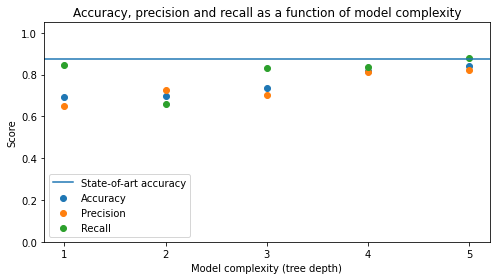

In [17]:
rtbust_scores = analyze_bot_repo_dataset(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json", PROJ_PATH + "/data/cresci-rtbust-2019.tsv", depth=2, soa_accuracy=0.8755)

## midterm-2018

Note: Too big to run on my computer right now.

-------------- DECISION TREE --------------
|--- user_created_at <= 1505082048.00
|   |--- weights: [7396.00, 584.00] class: 0.0
|--- user_created_at >  1505082048.00
|   |--- weights: [696.00, 41862.00] class: 1.0

Accuracy: 0.9746725236455737
Precision 0.9836458480191739
Recall: 0.9862413419403477
F1: 0.9849418850877606
Starting kfold_cv at 1653925446.3510287
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653925573.1245208. Execution time: 126.77349209785461 s
Starting kfold_cv at 1653925573.1250763
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653925727.5248122. Execution time: 154.3997359275818 s
Starting kfold_cv at 1653925727.5257976
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653925901.527805. Execution time: 174.00200748443604 s
Starting kfold_cv at 1653925901.52829
F

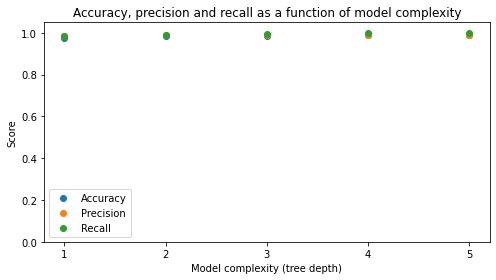

In [18]:
def midterm_extract_users(data_path):
    with open(data_path) as f:
        d = json.load(f)
    return d

def midterm_preprocess_users(profs, labels_path, dummy_cols):
    df = pd.DataFrame(profs).set_index("user_id")
    df["user_created_at"] = df["user_created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %Y").timestamp())
    labels = pd.read_csv(labels_path, sep="\t", header=None, names=["id", "label_str"], index_col="id")
    labels.loc[labels['label_str']=="human", 'label'] = 0
    labels.loc[labels['label_str']=="bot", 'label'] = 1
    df, labels = df.align(labels, join="inner", axis=0)
    df.reset_index(inplace=True)
    labels = labels['label']
    one_hot = preprocess(df, ['probe_timestamp', 'screen_name', 'name', 'description', 'url'], dummy_cols)
    return df, one_hot, labels

def analyze_midterm_dataset(data_path, labels_path, depth=1, soa_accuracy=None, soa_precision=None, soa_recall=None):
    profs = midterm_extract_users(data_path)
    dummy_cols = ['lang', 'protected', 'verified', 'geo_enabled', 'profile_use_background_image', 'default_profile', 'index']
    df, one_hot, labels = midterm_preprocess_users(profs, labels_path, dummy_cols)
    # Fit and score on decision tree
    print("-------------- DECISION TREE --------------")
    dt_clf, *_ = fit_and_score(one_hot, labels, depth=depth)
    plot_metrics(one_hot, labels, soa_accuracy=soa_accuracy, soa_precision=soa_precision, soa_recall=soa_recall)
    # Fit and score on decision tree
#     print("-------------- DECISION TREE TRAIN/TEST SPLIT --------------")
#     train_test_fit_and_score(one_hot, labels, depth=depth)
#     # Fit and score on random forest
#     print("-------------- RANDOM FOREST --------------")
#     rf = ensemble.RandomForestClassifier(n_estimators=100)
#     rf_clf, *_ = fit_and_score(one_hot, labels, method=rf)
#     fig, axes = plt.subplots(1,2, figsize=(15,7))
#     mdi_feature_importance(rf_clf, list(one_hot.columns), axes[0])
#     permutation_feature_importance(axes[1], df, labels, dummy_cols)
#     fig.tight_layout()
    return [kfold_cv(one_hot, labels, depth=i) for i in range(1,6)]

midterm2018_scores = analyze_midterm_dataset(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json", PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv", depth=1)

## gilani-2017

-------------- DECISION TREE --------------
|--- statuses_count <= 90439.00
|   |--- favourites_count <= 1471.50
|   |   |--- statuses_count <= 34842.50
|   |   |   |--- weights: [321.00, 180.00] class: 0.0
|   |   |--- statuses_count >  34842.50
|   |   |   |--- weights: [90.00, 171.00] class: 1.0
|   |--- favourites_count >  1471.50
|   |   |--- statuses_count <= 50663.00
|   |   |   |--- weights: [710.00, 145.00] class: 0.0
|   |   |--- statuses_count >  50663.00
|   |   |   |--- weights: [167.00, 96.00] class: 0.0
|--- statuses_count >  90439.00
|   |--- favourites_count <= 3001.00
|   |   |--- has_extended_profile_True <= 0.50
|   |   |   |--- weights: [10.00, 264.00] class: 1.0
|   |   |--- has_extended_profile_True >  0.50
|   |   |   |--- weights: [16.00, 55.00] class: 1.0
|   |--- favourites_count >  3001.00
|   |   |--- statuses_count <= 142930.50
|   |   |   |--- weights: [67.00, 56.00] class: 0.0
|   |   |--- statuses_count >  142930.50
|   |   |   |--- weights: [32.00, 123

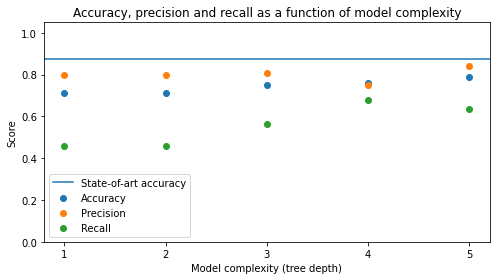

In [19]:
gilani_scores = analyze_bot_repo_dataset(PROJ_PATH + "/data/gilani-2017_tweets.json", PROJ_PATH + "/data/gilani-2017.tsv", depth=3, soa_accuracy=0.8755)

## cresci-2017: "The paradigm-shift of social spambots: Evidence, theories, and tools for the arms race."

Cresci, S., Di Pietro, R., Petrocchi, M., Spognardi, A., & Tesconi, M. (2017, April). The paradigm-shift of social spambots: Evidence, theories, and tools for the arms race. In Proceedings of the 26th International Conference on World Wide Web Companion (pp. 963-972). ACM.

https://arxiv.org/abs/1701.03017

Approx. citations: 328

Simple decision rule precision/recall: 0.98/0.98

State-of-art precision/recall: 0.98/0.98

In [20]:
# Load in data
folder_names = ['fake_followers', 
 'genuine_accounts', 
 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
is_bot = [1, 0, 1, 1, 1, 1, 1, 1, 1]
dfs = []
cresci2017_labels = []

for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/users.csv")
    dfs.append(df)
    cresci2017_labels.extend([ib]*len(df))

    
def format_time(dt):
    try:
        datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp()
    except:
        print(dt)
    
cresci2017 = pd.concat(dfs)



# Preprocess
cresci2017_one_hot = preprocess(cresci2017, 
                        COLUMNS_TO_DROP + ['profile_banner_url', 
                                                        'test_set_1', 
                                                        'test_set_2', 
                                                        'crawled_at',
                                                        'updated', 
                                                        'timestamp',
                                                        'following', 
                                                        'follow_request_sent',
                                                        'created_at'
                                                  ], 
                        DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications'])

# Fit and score decision tree
fit_and_score(cresci2017_one_hot, cresci2017_labels, depth=1)

|--- favourites_count <= 16.50
|   |--- weights: [186.00, 10744.00] class: 1
|--- favourites_count >  16.50
|   |--- weights: [3288.00, 150.00] class: 0

Accuracy: 0.9766146993318485
Precision 0.9829826166514181
Recall: 0.9862309528180649
F1: 0.9846041055718475


(DecisionTreeClassifier(max_depth=1),
 0.9766146993318485,
 0.9829826166514181,
 0.9862309528180649,
 0.9846041055718475)

In [21]:
cresci2017_scores = [kfold_cv(cresci2017_one_hot, cresci2017_labels, depth=i) for i in range(1,6)]

Starting kfold_cv at 1653926309.7915256
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926313.92203. Execution time: 4.130504369735718 s
Starting kfold_cv at 1653926313.9221396
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926318.983376. Execution time: 5.061236381530762 s
Starting kfold_cv at 1653926318.98357
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926324.5497231. Execution time: 5.566153049468994 s
Starting kfold_cv at 1653926324.5498343
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926330.6179478. Execution time: 6.068113565444946 s
Starting kfold_cv at 1653926330.6184328
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1

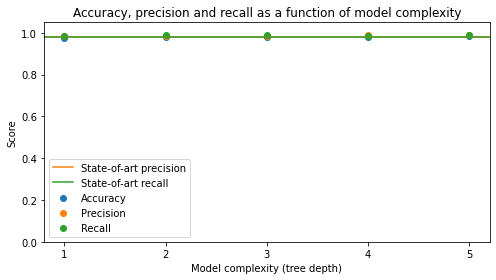

In [16]:
plot_metrics(cresci2017_one_hot, cresci2017_labels, soa_precision=0.98, soa_recall=0.98)

In [17]:
train_test_fit_and_score(cresci2017_one_hot, cresci2017_labels, depth=1)

|--- favourites_count <= 16.50
|   |--- weights: [127.00, 7510.00] class: 1
|--- favourites_count >  16.50
|   |--- weights: [2315.00, 105.00] class: 0

Accuracy: 0.9758756668986314
Precision 0.9820832068023079
Recall: 0.9862763037511436
F1: 0.9841752891052952


In [18]:
# Fit and score on random forest
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf, *_ = fit_and_score(cresci2017_one_hot, cresci2017_labels, method=rf)

Accuracy: 1.0
Precision 1.0
Recall: 1.0
F1: 1.0


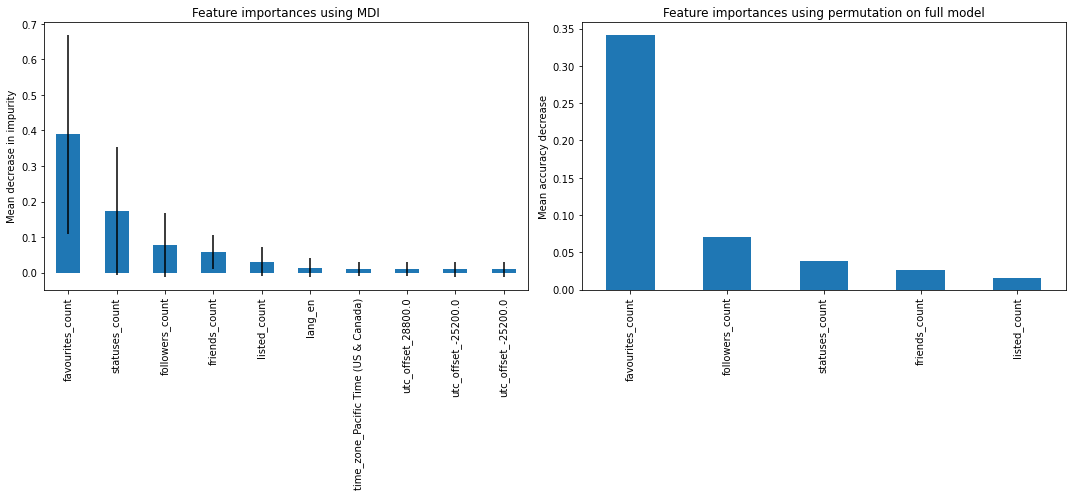

In [19]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
mdi = mdi_feature_importance(rf_clf, list(cresci2017_one_hot.columns), axes[0])
permutation_feature_importance(axes[1], cresci2017, cresci2017_labels, DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications',])
fig.tight_layout()

## varol-2017

Bot repository only has account ids and labels. Reached out to http://sbp-brims.org/2021/papers/working-papers/2021_SBP-BRiMS_FinalPDF_57.pdf to get full data.

## cresci-2015

In [22]:
folder_names = ["elzioni2013", "TheFakeProject", "intertwitter", "twittertechnology", "fastfollowerz"]
is_bot = [0, 0, 1, 1, 1]

dfs = []
cresci2015_labels = []

for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(PROJ_PATH + f"/data/cresci-2015/{name}/users.csv")
    #print(name, df["created_at"])
    dfs.append(df)
    cresci2015_labels.extend([ib]*len(df))

cresci2015 = pd.concat(dfs)
cresci2015["created_at"] = cresci2015["created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp())

# Preprocess
cresci2015_one_hot = preprocess(cresci2015, 
                        ['id', 'lang', 'name', 'screen_name',
                           'url', 'profile_image_url',
                           'profile_banner_url',
                           'profile_background_image_url_https', 'profile_text_color',
                           'profile_image_url_https', 'profile_sidebar_border_color',
                           'profile_sidebar_fill_color',
                           'profile_background_image_url', 'profile_background_color',
                           'profile_link_color',
                           'description', 'dataset', 'updated'], 
                        [col for col in DUMMY_COLUMNS if col not in ['lang']])


# Fit and score decision tree
fit_and_score(cresci2015_one_hot, cresci2015_labels, depth=1)

|--- statuses_count <= 78.50
|   |--- weights: [210.00, 3140.00] class: 1
|--- statuses_count >  78.50
|   |--- weights: [1740.00, 211.00] class: 0

Accuracy: 0.9205810224485946
Precision 0.9373134328358209
Recall: 0.9370337212772307
F1: 0.937173556185644


(DecisionTreeClassifier(max_depth=1),
 0.9205810224485946,
 0.9373134328358209,
 0.9370337212772307,
 0.937173556185644)

In [23]:
cresci2015_scores = [kfold_cv(cresci2015_one_hot, cresci2015_labels, depth=i) for i in range(1,6)]

Starting kfold_cv at 1653926338.1898541
Fold 0 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926339.3026977. Execution time: 1.1128435134887695 s
Starting kfold_cv at 1653926339.3031576
Fold 0 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926340.581442. Execution time: 1.2782845497131348 s
Starting kfold_cv at 1653926340.5819075
Fold 0 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926341.9844608. Execution time: 1.4025533199310303 s
Starting kfold_cv at 1653926341.984926
Fold 0 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926343.4898534. Execution time: 1.504927396774292 s
Starting kfold_cv at 1653926343.4903595
Fold 0 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926345.248086. Execution time: 1.7577264308929443 s


In [41]:
cresci2015_scores

[[0.915928369462771, 0.6909090909090909, 0.7500427415996318, 0.70254025456376],
 [0.8524470854061207,
  0.6976190476190476,
  0.6866885864034247,
  0.6704436909761873],
 [0.7702604690064978,
  0.7097643097643098,
  0.5965531284107456,
  0.5921249665753676],
 [0.7734649930404279, 0.7634615384615385, 0.5901780544349, 0.6114412572520597],
 [0.7978808303692363,
  0.7460176991150442,
  0.6106649524129424,
  0.6133245533660471]]

In [21]:
train_test_fit_and_score(cresci2015_one_hot, cresci2015_labels, depth=2)

|--- statuses_count <= 78.50
|   |--- friends_count <= 159.50
|   |   |--- weights: [117.00, 99.00] class: 0
|   |--- friends_count >  159.50
|   |   |--- weights: [23.00, 2105.00] class: 1
|--- statuses_count >  78.50
|   |--- friends_count <= 474.50
|   |   |--- weights: [925.00, 19.00] class: 0
|   |--- friends_count >  474.50
|   |   |--- weights: [288.00, 134.00] class: 0

Accuracy: 0.9226901319924575
Precision 0.9943246311010215
Recall: 0.8812877263581489
F1: 0.9343999999999999


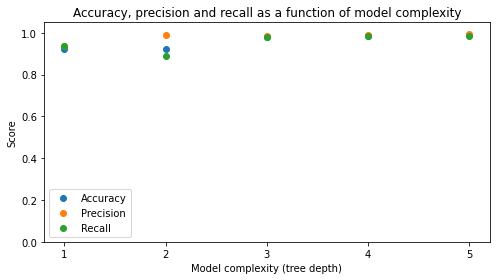

In [22]:
plot_metrics(cresci2015_one_hot, cresci2015_labels)

## caverlee-2011: "A Long-Term Study of Content Polluters on Twitter."

Lee, Kyumin, Brian David Eoff, and James Caverlee. "A Long-Term Study of Content Polluters on Twitter." ICWSM. 2011.

https://ojs.aaai.org/index.php/ICWSM/article/view/14106

Approx. citations: 500

Simple decision rule precision/recall: 0.91/0.92

State-of-art precision/recall: 0.89/0.87

In [27]:
caverlee2011_bots = pd.read_csv(PROJ_PATH + "/data/social_honeypot_icwsm_2011/content_polluters.txt", sep="\t", header=None, names=["UserID", "CreatedAt", "CollectedAt", "NumerOfFollowings", "NumberOfFollowers", "NumberOfTweets", "LengthOfScreenName", "LengthOfDescriptionInUserProfile"])
caverlee2011_humans = pd.read_csv(PROJ_PATH + "/data/social_honeypot_icwsm_2011/legitimate_users.txt", sep="\t", header=None, names=["UserID", "CreatedAt", "CollectedAt", "NumerOfFollowings", "NumberOfFollowers", "NumberOfTweets", "LengthOfScreenName", "LengthOfDescriptionInUserProfile"])
caverlee2011 = pd.concat([caverlee2011_bots, caverlee2011_humans])
caverlee2011["CreatedAt"] = caverlee2011["CreatedAt"].apply(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").timestamp())
caverlee2011.drop(columns=["CollectedAt", "UserID"], inplace=True)
caverlee2011_labels = [1]*len(caverlee2011_bots) + [0]*len(caverlee2011_humans)


In [24]:
nonnumeric(caverlee2011)

Columns with NA values: Series([], dtype: bool)
Columns with dtype=object []
Columns with dtype=bool []


In [25]:
fit_and_score(caverlee2011, caverlee2011_labels, depth=2)

|--- CreatedAt <= 1259512448.00
|   |--- NumerOfFollowings <= 502.50
|   |   |--- weights: [17261.00, 1879.00] class: 0
|   |--- NumerOfFollowings >  502.50
|   |   |--- weights: [2015.00, 7856.00] class: 1
|--- CreatedAt >  1259512448.00
|   |--- weights: [0.00, 12488.00] class: 1

Accuracy: 0.9061664136485217
Precision 0.9098796905049421
Recall: 0.9154479593214238
F1: 0.9126553317482392


(DecisionTreeClassifier(max_depth=2),
 0.9061664136485217,
 0.9098796905049421,
 0.9154479593214238,
 0.9126553317482392)

In [28]:
caverlee2011_scores = [kfold_cv(caverlee2011, caverlee2011_labels, depth=i) for i in range(1,6)]

Starting kfold_cv at 1653926539.3931081
Fold 0 in progress
Fold 1 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2 in progress
Fold 3 in progress
Fold 4 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished kfold_cv at 1653926539.8676667. Execution time: 0.47455859184265137 s
Starting kfold_cv at 1653926539.8677444
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926540.3023846. Execution time: 0.43464016914367676 s
Starting kfold_cv at 1653926540.3024414
Fold 0 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1 in progress
Fold 2 in progress
Fold 3 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4 in progress
Finished kfold_cv at 1653926540.8376312. Execution time: 0.5351898670196533 s
Starting kfold_cv at 1653926540.8378518
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished kfold_cv at 1653926541.510075. Execution time: 0.6722233295440674 s
Starting kfold_cv at 1653926541.5104582
Fold 0 in progress
Fold 1 in progress
Fold 2 in progress
Fold 3 in progress
Fold 4 in progress
Finished kfold_cv at 1653926542.1921275. Execution time: 0.6816692352294922 s


/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/software/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
caverlee2011_scores

[[0.4121204819277109,
  0.3574775563827458,
  0.277975543647112,
  0.3126337689624016],
 [0.48520481927710846,
  0.3705489839247801,
  0.3743132530120482,
  0.3703793843696347],
 [0.48908433734939766,
  0.5875515818431912,
  0.3615793353031546,
  0.3731163285639149],
 [0.5068433734939759,
  0.5871214642262895,
  0.38267469879518073,
  0.38432669111662776],
 [0.4234698795180723,
  0.5604737442922374,
  0.328289156626506,
  0.3344125171111247]]

In [26]:
train_test_fit_and_score(caverlee2011, caverlee2011_labels, depth=2)

|--- CreatedAt <= 1259513664.00
|   |--- NumerOfFollowings <= 498.50
|   |   |--- weights: [12086.00, 1317.00] class: 0
|   |--- NumerOfFollowings >  498.50
|   |   |--- weights: [1407.00, 5558.00] class: 1
|--- CreatedAt >  1259513664.00
|   |--- weights: [0.00, 8681.00] class: 1

Accuracy: 0.9057831325301204
Precision 0.9078087885985748
Recall: 0.9172041397930103
F1: 0.9124822800865479


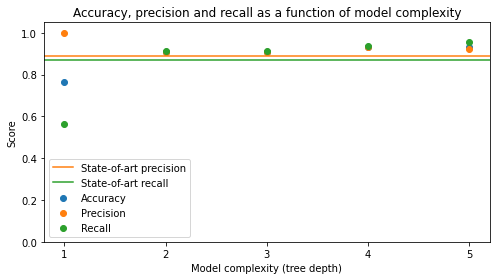

In [27]:
plot_metrics(caverlee2011, caverlee2011_labels, soa_precision=0.89, soa_recall=0.87)

In [28]:
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10)
rf_clf, _, _, _, _ = fit_and_score(caverlee2011, caverlee2011_labels, method=rf, depth=2)

Accuracy: 0.9526253644666136
Precision 0.9538875196056464
Recall: 0.9578364757233497
F1: 0.9558579190803359


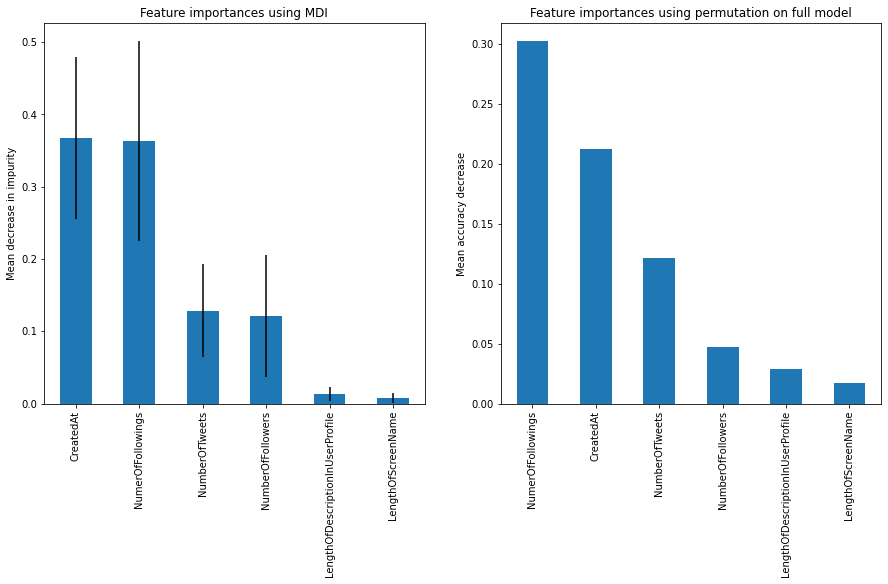

In [29]:
fig, axes =plt.subplots(1, 2, figsize=(15,7))
mdi_feature_importance(rf_clf, list(caverlee2011.columns), axes[0])
permutation_feature_importance(axes[1], caverlee2011, caverlee2011_labels, [])

## Kaiser

Only account ids and labels.

In [33]:
kaiser = pyreadr.read_r(PROJ_PATH + '/data/kaiser/data_botometer.RData')['data_botometer']

In [34]:
kaiser

,user.id_str,date,type,cap.universal,scores.universal
0,1073515275323097088,2019-03-03,bot,0.325413,0.724840
1,961438005675397120,2019-03-03,bot,0.104603,0.515643
2,941291900862124032,2019-03-03,bot,0.060559,0.413570
3,809439447796355072,2019-03-03,bot,0.060559,0.413570
4,769777732213321729,2019-03-03,bot,0.054305,0.393746
...,...,...,...,...,...
374719,2234767742,2019-06-02,ger_bot,0.104603,0.515643
374720,1092190045,2019-06-02,ger_bot,0.010165,0.170132
374721,57146860,2019-06-02,ger_bot,0.023812,0.267344
374722,56828167,2019-06-02,ger_bot,0.005778,0.119570


# Single-class datasets

## Astroturf

Only account ids and labels.

## botwiki-2019

In [36]:
botwiki_profs = extract_users(PROJ_PATH + "/data/botwiki-2019_tweets.json")
botwiki_df, botwiki_one_hot, botwiki_labels = preprocess_users(botwiki_profs, PROJ_PATH + "/data/botwiki-2019.tsv")

## celebrity-2019

In [37]:
celebrity_profs = extract_users(PROJ_PATH + "/data/celebrity-2019_tweets.json")
celebrity_df, celebrity_one_hot, celebrity_labels = preprocess_users(celebrity_profs, PROJ_PATH + "/data/celebrity-2019.tsv")

## political-bots-2019

In [38]:
political_bots_profs = extract_users(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json")
political_bots_df, political_bots_one_hot, political_bots_labels = preprocess_users(political_bots_profs, PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")

## pronbots-2019

In [39]:
def extract_users_list(data_path):
    with open(data_path) as f:
        d = json.load(f)
    return d

pronbots_profs = extract_users_list(PROJ_PATH + "/data/pronbots-2019_tweets.json")
pronbots_df, pronbots_one_hot, pronbots_labels = preprocess_users(pronbots_profs, PROJ_PATH + "/data/pronbots-2019.tsv")

KeyError: "None of ['id'] are in the columns"

In [39]:
pronbots_one_hot

,followers_count,friends_count,listed_count,created_at,favourites_count,statuses_count


## vendor-purchased-2019

In [40]:
vendor_purchased_profs = extract_users(PROJ_PATH + "/data/vendor-purchased-2019_tweets.json")
vendor_purchased_df, vendor_purchased_one_hot, vendor_purchased_labels = preprocess_users(vendor_purchased_profs, PROJ_PATH + "/data/vendor-purchased-2019.tsv")

## analysis of each of the specialized classifiers in Botometer

### humans

In [ ]:
human_df = pd.concat([caverlee2011_humans], axis=0)

### simple bots

In [20]:
simple_df = caverlee2011_bots

### spammers

In [28]:
# Load in cresci data
folder_names = [ 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
dfs = []

for name in folder_names:
    df = pd.read_csv(f"./data/cresci-2017/{name}.csv/users.csv")
    dfs.append(df)

    
def format_time(dt):
    try:
        datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp()
    except:
        print(dt)
    
cresci2017_spammers = pd.concat(dfs)



# Preprocess
cresci2017_one_hot = preprocess(cresci2017_spammers, 
                        COLUMNS_TO_DROP + ['profile_banner_url', 
                                                        'test_set_1', 
                                                        'test_set_2', 
                                                        'crawled_at',
                                                        'updated', 
                                                        'timestamp',
                                                        'following', 
                                                        'follow_request_sent',
                                                        'created_at'
                                                  ], 
                        DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications'])

spammers_df = pd.concat([pronbots_one_hot, cresci2017_one_hot], ignore_index=True)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [31]:
cresci2017_one_hot

,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang_en,lang_en-gb,lang_it,lang_ja,lang_nl,...,utc_offset_-14400.0,utc_offset_-7200.0,utc_offset_0.0,utc_offset_3600.0,utc_offset_7200.0,utc_offset_10800.0,utc_offset_14400.0,utc_offset_21600.0,utc_offset_25200.0,utc_offset_32400.0
0,1299,22,40,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,18665,12561,3442,16358,110,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,22987,600,755,14,6,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,7975,398,350,11,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20218,413,405,162,8,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,41,169,151,0,12,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1124,218,332,245,0,31,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,17,530,300,0,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1126,2,247,202,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### fake followers

### self-declared

### political bots

### other bots

## EMD-2017: "Twitter fake account detection"

All accounts are fake. 

In [41]:
# Load data
data = arff.loadarff('data/EMD-2017/Twitter_dataset.arff')
emd = pd.DataFrame(data[0])

for col in emd:
    if (type(emd[col][0]) == type(b'str')):
        emd[col] = emd[col].apply(bool)

emd.head()

emd_labels = emd['is_fake'].apply(lambda x: 1 if x else 0)

In [38]:
# Preprocess
emd_one_hot = preprocess(emd, ['is_fake'], ['protected', 'profile_use_background_image', 'verified', 'contributors_enabled', 'default_profile', 'default_profile_image', 'is_translator'])

# Fit and score decision tree
fit_and_score(emd_one_hot, emd_labels, depth=1)

|--- class: 0

In-sample accuracy: 1.0
In-sample precision score: 1.0
In-sample recall score: 1.0
In-sample F1 score: 1.0


(DecisionTreeClassifier(max_depth=1), 1.0, 1.0, 1.0, 1.0)

# Text-based classification

## PAN19

In [30]:
def get_tweets_xml(path):
    with open(path) as xmlfile:
        tree = ET.parse(xmlfile)
        tweets = (document.text for document in tree.getroot()[0])
        tweets_joined = " ".join(tweets)
        return tweets_joined
    
def get_labels(path):
    d = dict()
    with open(path) as file:
        for line in file:
            labels = line.split(":::")
            d[labels[0]] = 1 if labels[1] == 'bot' else 0
    return pd.DataFrame.from_dict(d, orient='index', columns=['label'])

def get_tweets_pan19(index):
    d = {ind : get_tweets_xml(PROJ_PATH + f"/data/pan19/pan19-author-profiling-training-2019-02-18/en/{ind}.xml") for ind in index}
    return pd.DataFrame.from_dict(d, orient='index', columns=['tweets'])
        
# Get dataframe of labels and tweets
pan19_labels = get_labels(PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/truth.txt")
pan19_tweets = get_tweets_pan19(pan19_labels.index)
# Get count vectorizer df
pan19_cv = CountVectorizer(stop_words='english') 
pan19_cv_matrix = pan19_cv.fit_transform(pan19_tweets['tweets']) 
pan19_cv_df = pd.DataFrame(pan19_cv_matrix.toarray(), index=pan19_tweets.index, columns=pan19_cv.get_feature_names())

In [31]:
fit_and_score(pan19_cv_df.loc[pan19_labels.index].drop(['tweets', 'label'], axis=1), pan19_labels, depth=3)

|--- rt <= 1.50
|   |--- webinar <= 0.50
|   |   |--- merci <= 0.50
|   |   |   |--- weights: [59.00, 1720.00] class: 1
|   |   |--- merci >  0.50
|   |   |   |--- weights: [13.00, 0.00] class: 0
|   |--- webinar >  0.50
|   |   |--- iii <= 0.50
|   |   |   |--- weights: [28.00, 0.00] class: 0
|   |   |--- iii >  0.50
|   |   |   |--- weights: [0.00, 2.00] class: 1
|--- rt >  1.50
|   |--- rt <= 99.50
|   |   |--- https <= 1.50
|   |   |   |--- weights: [102.00, 114.00] class: 1
|   |   |--- https >  1.50
|   |   |   |--- weights: [1854.00, 154.00] class: 0
|   |--- rt >  99.50
|   |   |--- struggling <= 0.50
|   |   |   |--- weights: [1.00, 69.00] class: 1
|   |   |--- struggling >  0.50
|   |   |   |--- weights: [3.00, 1.00] class: 0

Accuracy: 0.9230582524271844
Precision 0.9216255442670537
Recall: 0.9247572815533981
F1: 0.9231887569663194


(DecisionTreeClassifier(max_depth=3),
 0.9230582524271844,
 0.9216255442670537,
 0.9247572815533981,
 0.9231887569663194)

In [32]:
plot_metrics(pan19_cv_df.loc[pan19_labels.index].drop(['tweets', 'label'], axis=1), pan19_labels)

KeyboardInterrupt: 

## cresci-2017

In [4]:
# Load in data
folder_names = ['fake_followers', 
 'genuine_accounts', 
 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1']
is_bot = [1, 0, 1, 1, 1, 1]
tweets = []
cresci2017_labels = []

for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')
    df['text'] = df['text'].apply(lambda x: "" if isinstance(x, float) else x)
    df_groups = df[['text', 'user_id']].groupby(['user_id'])
    df_tweets = df_groups['text'].apply(lambda x: " ".join(x))
    tweets.append(df_tweets)
    print(name, len(df_tweets))
    cresci2017_labels.extend([ib]*len(df_tweets))
    
def format_time(dt):
    try:
        datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp()
    except:
        print(dt)
        
cresci2017_tweets = pd.concat(tweets)

<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


fake_followers 3202


<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


genuine_accounts 1083


<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_1 991


<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_2 3457


<ipython-input-4-9fbcf55adced>:13: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_3 464
traditional_spambots_1 1000


In [27]:

eqs = []
for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')
    eq = df[[(isinstance(row, str)) and ('earthquake' in row) for row in df['text']]]
    eqs.append(eq)
    print(name, len(eq))
    
cresci2017 = pd.concat(eqs)

<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


fake_followers 17


<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


genuine_accounts 5081


<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_1 2


<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_2 9


<ipython-input-27-d4030157cae8>:3: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROJ_PATH + f"/data/cresci-2017/{name}.csv/tweets.csv", encoding='latin-1')


social_spambots_3 6
traditional_spambots_1 18


In [39]:
import random

random.sample(list(cresci2017['text']), 5)

['Volcanes D. Light mag. 4.2 earthquake  - Crete, Greece on Sunday, 19 April 2015:  http://t.co/bpGRpKH9Qd',
 'I felt no type of earthquake',
 "RT @jonk: Bunch of us huddled in the middle of an intersection away from things we've seen fall. #Kathmandu #earthquake http://t.co/Homswcjâ\x80¦",
 'Road buckle on Hwy 12, Napa, CA. #earthquake http://t.co/ogR5DXNPLL',
 'RT @cctvnews: Pic:â\x80\x9dLoveâ\x80\x9d from above: victims of the 2013 Yaâ\x80\x98an earthquake give thanks to those who helped them rebuild. http://t.co/ZT1W0Glâ\x80¦']

In [40]:
# Get count vectorizer df
cresci2017_cv = CountVectorizer(stop_words='english', min_df=5) 
cresci2017_cv_matrix = cresci2017_cv.fit_transform(cresci2017_tweets) 

In [41]:
cresci2017_cv_df = pd.DataFrame(cresci2017_cv_matrix.toarray(), index=cresci2017_tweets.index, columns=cresci2017_cv.get_feature_names())

In [46]:
fit_and_score(cresci2017_cv_df, cresci2017_labels, depth=2)

|--- earthquake <= 0.50
|   |--- https <= 30.50
|   |   |--- weights: [27.00, 9054.00] class: 1
|   |--- https >  30.50
|   |   |--- weights: [61.00, 16.00] class: 0
|--- earthquake >  0.50
|   |--- https <= 0.50
|   |   |--- weights: [39.00, 34.00] class: 0
|   |--- https >  0.50
|   |   |--- weights: [956.00, 10.00] class: 0

In-sample accuracy: 0.9914680788467196
In-sample precision score: 0.9970267591674926
In-sample recall score: 0.9934167215273206
In-sample F1 score: 0.9952184666117065


(DecisionTreeClassifier(max_depth=2),
 0.9914680788467196,
 0.9970267591674926,
 0.9934167215273206,
 0.9952184666117065)

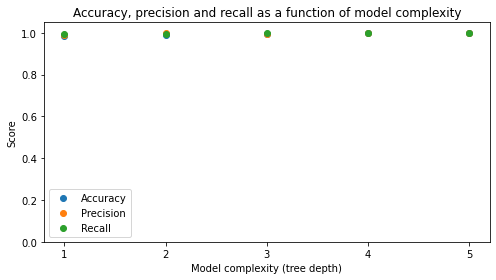

In [43]:
plot_metrics(cresci2017_cv_df, cresci2017_labels)

# Plotting performance of network stats on single plot

In [43]:
names = [
    "twibot", 
    "botometer-feedback", 
    "rtbust", 
    "midterm-2018", 
    "gilani", 
    "cresci-2017", 
    "cresci-2015", 
    "caverlee-2011"]
scores = [twibot_scores,
         botometer_feedback_scores,
         rtbust_scores,
         midterm2018_scores,
         gilani_scores,
         cresci2017_scores,
         cresci2015_scores,
         caverlee2011_scores]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

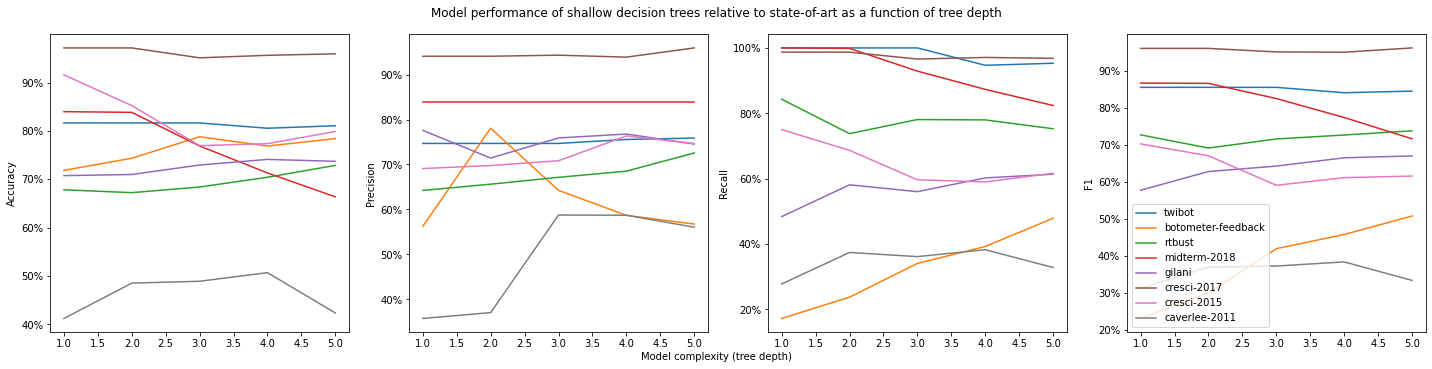

In [49]:
fig, axes = plt.subplots(1,4, figsize=(20, 5))

for i, metric_name in enumerate(metric_names):
    for name, scr in zip(names, scores):
        metric_i = [item[i]*100 for item in scr]
        axes[i].plot(range(1,6), metric_i, label=name)
    axes[i].set_ylabel(metric_name)
    yticks = mtick.PercentFormatter(is_latex=True)
    axes[i].yaxis.set_major_formatter(yticks)
axes[3].legend()
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Model performance of shallow decision trees relative to state-of-art as a function of tree depth")
fig.tight_layout()
plt.show()